## Quick analysis of the chosen regions where new stations were added



In [2]:
#import warnings
#warnings.filterwarnings('ignore')
import os

import geopandas as gpd
import folium as fl
import pandas as pd






In [3]:
#load geopandas dframes with station lists

added_202201=gpd.read_file("stations_added_202201.shp")
added_202202=gpd.read_file("stations_added_202202.shp")
added_202203=gpd.read_file("stations_added_202203.shp")

added_202301=gpd.read_file("stations_added_202301.shp")
added_202302=gpd.read_file("stations_added_202302.shp")
added_202303=gpd.read_file("stations_added_202303.shp")

all_stations = gpd.read_file("all_vejvejr_stations_2023.shp")

### load domains


In [4]:
fyn_pol = gpd.read_file("around_fyn.geojson")

nez_pol = gpd.read_file("around_ne_zealand.geojson")
mju_pol = gpd.read_file("somewhere_midjutland.geojson")

#stations_vv.crs = {'init': 'EPSG:4326'}
#points_kastrup = gpd.sjoin(stations_vv, df_kastrup, op = 'within')
#points_kastrup = gpd.sjoin(df_kastrup, stations_vv,op = 'contains')
#points_kastrup.head(10)

In [5]:
m = fl.Map(zoom_start=100, layers_control=True, tiles="OpenStreetMap")
for _, r in fyn_pol.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "none"})
    geo_j.add_to(m)
for _, r in nez_pol.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "none"})
    geo_j.add_to(m)
for _, r in mju_pol.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "none"})
    geo_j.add_to(m)
    
m    

In [6]:
# Read the station data also in geopandas format and do extraction


In [8]:
from pathlib import Path
from collections import OrderedDict
stations=OrderedDict()

for f in sorted(Path(".").glob("stations_added*shp")):
    fname = str(f)
    when = fname.split("_")[2].replace(".shp","")
    st_read = gpd.read_file(f)
    stations[when] = st_read
    #print(when)
#geo_202201.to_file("stations_added_202301.shp")


In [9]:
stations.keys()

odict_keys(['202201', '202202', '202203', '202301', '202302', '202303'])

In [10]:
#select matches from data on selected regions

#Fyn

sel_fyn = OrderedDict()
for yyyymm in stations.keys():
    match = gpd.sjoin(stations[yyyymm],fyn_pol,op="within")
    size = match.shape[0]
    print(f"{yyyymm} has {size}")
    sel_fyn[yyyymm] = match
    #print(match)
    
#match_kas_2202 = gpd.sjoin(df_kas,geo_obs_2202,op = 'contains')

# mid jutland


202201 has 0
202202 has 0
202203 has 17
202301 has 0
202302 has 1
202303 has 0


In [11]:
#select math with all stations in the selected regions
stations_fyn = gpd.sjoin(all_stations,fyn_pol,op="within")
stations_mju = gpd.sjoin(all_stations,mju_pol,op="within")
stations_nez = gpd.sjoin(all_stations,nez_pol,op="within")

In [12]:
size_mju = stations_mju.shape[0]
size_nez = stations_nez.shape[0]
size_fyn = stations_fyn.shape[0]
print(size_mju)
print(size_nez)
print(size_fyn)
#for key in sel_fyn.keys():
#    #print(sel_fyn[key])

27
30
64


# Reading all the observations

In [13]:
import sqlite3
import pandas as pd
dbase="data/stations_coords_height.db"
con=sqlite3.connect(dbase)
com="SELECT * FROM roadstations"
df_stations = pd.read_sql(com,con)
con.close()

df_obs = OrderedDict()
# read the observational data
for year in ["2022","2023"]:
    OBS="/home/cap/Downloads/ROAD_MODEL_DATA/OBSTABLE_TROAD_"+year+".sqlite"
    com="SELECT * FROM SYNOP"
    con=sqlite3.connect(OBS)
    df_obs[year] = pd.read_sql(com,con)
    con.close()
    df_obs[year]["datetime"] = pd.to_datetime(df_obs[year]["validdate"],unit="s")
import calendar
from datetime import datetime

for year in ["2022","2023"]:
    for month in [1,2,3]:
        lday = calendar.monthrange(int(year), month)[1]
        print(lday)
        beg_month = datetime(int(year),month,1)
        end_month = datetime(int(year),month,lday)
        df_obs[year+str(month).zfill(2)] = df_obs[year][(df_obs[year]["datetime"] >= beg_month) & (df_obs[year]["datetime"] <= end_month)]



31
28
31
31
28
31


In [14]:
for key in df_obs.keys():
    print(key)

2022
2023
202201
202202
202203
202301
202302
202303


In [15]:
# conver the obs data to geopandas to do GIS operations below
gdf_obs=OrderedDict()
for key in df_obs.keys():
    gdf_obs[key] = gpd.GeoDataFrame(
    df_obs[key], geometry=gpd.points_from_xy(df_obs[key].lon, df_obs[key].lat), crs="EPSG:4326"
)


In [16]:
gdf_obs["202303"]

,validdate,SID,lat,lon,elev,TROAD,datetime,geometry
821479,1677628800,100001,55.995688,12.48658,58.560295,-2.2,2023-03-01 00:00:00,POINT (12.48658 55.99569)
821480,1677632400,100001,55.995688,12.48658,58.560295,-2.5,2023-03-01 01:00:00,POINT (12.48658 55.99569)
821481,1677636000,100001,55.995688,12.48658,58.560295,-2.6,2023-03-01 02:00:00,POINT (12.48658 55.99569)
821482,1677639600,100001,55.995688,12.48658,58.560295,-2.5,2023-03-01 03:00:00,POINT (12.48658 55.99569)
821483,1677643200,100001,55.995688,12.48658,58.560295,-2.7,2023-03-01 04:00:00,POINT (12.48658 55.99569)
...,...,...,...,...,...,...,...,...
1334206,1680206400,622900,57.044820,8.74965,4.897071,5.3,2023-03-30 20:00:00,POINT (8.74965 57.04482)
1334207,1680210000,622900,57.044820,8.74965,4.897071,5.2,2023-03-30 21:00:00,POINT (8.74965 57.04482)
1334208,1680213600,622900,57.044820,8.74965,4.897071,5.1,2023-03-30 22:00:00,POINT (8.74965 57.04482)
1334209,1680217200,622900,57.044820,8.74965,4.897071,5.0,2023-03-30 23:00:00,POINT (8.74965 57.04482)


In [17]:
list_nze = stations_nez["SID"].to_list()
list_fyn = stations_fyn["SID"].to_list()
list_mju = stations_mju["SID"].to_list()

In [18]:
# compare the stations present on the same month in 2022 and 2023
tooltip = "Click Here For Station name"


loc = 'Stations in Fyn on March 2023'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m = fl.Map(zoom_start=50, layers_control=True, tiles="OpenStreetMap")
for _, r in stations_fyn.iterrows():
    #print(r)
    station = r["SID"]
    this_lat = r["lat"]
    this_lon = r["lon"]
    #print(f"lat: {this_lat}, lon: {this_lon} for {station}")
    icon=fl.Icon(color='black')
    marker = fl.Marker(
        location=[this_lat, this_lon],
        popup=f"<stong> {station}</stong>",
        tooltip=tooltip, icon=icon)
    marker.add_to(m)



m.get_root().html.add_child(fl.Element(title_html))
    
m
#m.save('map.html')



Checking station data from other years when there was fewer stations

In [19]:
df_obs["202303"]["partial_SID"] = [int(str(sid)[0:4]) for sid in df_obs["202303"]["SID"]]
df_obs["202203"]["partial_SID"] = [int(str(sid)[0:4]) for sid in df_obs["202203"]["SID"]]


In [20]:
#df_obs["202303"]["partial_SID"]

In [21]:
obs_202303_fyn = df_obs["202303"].loc[df_obs["202303"]["partial_SID"].isin(list_fyn)]
obs_202203_fyn = df_obs["202203"].loc[df_obs["202203"]["partial_SID"].isin(list_fyn)]


In [22]:
#quick and dirty renaming of the 
#obs_202303_fyn.rename(columns={"TROAD": "TROAD_202303"},inplace=True)
#obs_202203_fyn.rename(columns={"TROAD":"TROAD_202203"},inplace=True)


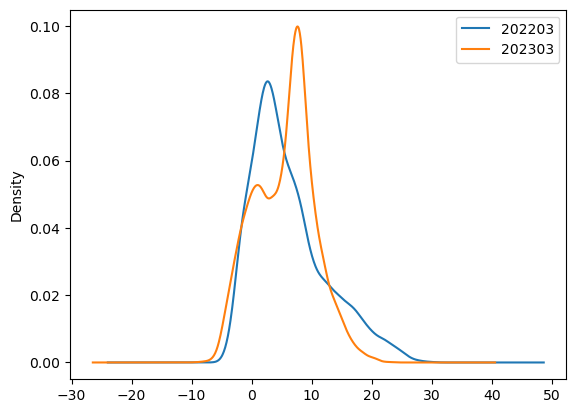

In [23]:
from matplotlib import pyplot as plt
#fig = plt.figure(figsize=[12,9])
fig, ax = plt.subplots()
p1=obs_202203_fyn["TROAD"].plot.density(legend="obs dist 202203")#hist(alpha=0.5)
p2=obs_202303_fyn["TROAD"].plot.density(legend="obs dist 202303")#hist(alpha=0.5)
p1.legend(["202203","202303"])

#p2.legend(["202203"])

#ax.legend(loc="best")
#noon_fcst["glatmodel_det"].plot.density(legend="fcst")#.hist()

#plt.show()

In [ ]:
#load the forecast data for the corresponding month
